In [1]:
cd ~/Desktop/DeepLearningPilot/

/Users/jz-rolling/Desktop/DeepLearningPilot


In [85]:
import tensorflow as tf,matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize,rescale
from skimage import measure, segmentation,morphology,filters,feature,exposure
import tifffile
import momia2 as mo
from momia2.classify.classifier_helper import *
import timeit
import pickle as pk
from tensorflow import keras
from unet import *
import glob, os
import seaborn as sns
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
from matplotlib import cm
from microfilm.microplot import microshow

In [5]:
for f in glob.glob('/Volumes/JZSSD_temp/202212_Harry_flow/20221220_mero_batch/*'):
    new_f = '/Volumes/JZSSD_temp/202212_Harry_flow/20221220_mero_batch/{}/'.format(f.split('/')[-1].split('_')[0])
    if not os.path.isdir(new_f):
        os.mkdir(new_f)
    os.rename(f,new_f+f.split('/')[-1])

In [166]:
fitc_range = [500,2000]
root =  '/Volumes/JZSSD_temp/202212_Harry_flow/20221220_mero_batch/B10/'
well = root.split('/')[-2]
for count,f in enumerate(glob.glob(root+'*.pk')):
    p = pk.load(open(f,'rb'))
    out_folder = root + 'thumbnails/'
    if not os.path.isdir(out_folder):
        os.mkdir(out_folder)
    thumbnails(p,out_folder,'{}-{}'.format(well,count),channel_range = [fitc_range,[2000,16000]],scale_bar_length=0)
    break
    
if well.startswith('A'):
    rapa = 'C'
else:
    rapa = 'D'
root =  '/Volumes/JZSSD_temp/202212_Harry_flow/20221220_mero_batch/{}{}/'.format(rapa,well[1:])
well = root.split('/')[-2]
for count,f in enumerate(glob.glob(root+'*.pk')):
    p = pk.load(open(f,'rb'))
    out_folder = root + 'thumbnails/'
    if not os.path.isdir(out_folder):
        os.mkdir(out_folder)
    thumbnails(p,out_folder,'{}-{}'.format(well,count),channel_range = [fitc_range,[2000,16000]],scale_bar_length=5,min_neighbor_count=3,max_neighbor_count=10)
    break

In [103]:
def thumbnails(patch,
               output_folder = '',
               img_id='0',
               fig_size=(4,4),
               channels = ['FITC','Phase_Ian'],
               scale_bar_length=5,
               channel_range = [[500,3000],[2000,20000]],
               cmaps=['pure_green','gist_gray'],
               distance_threshold=120,
               min_neighbor_count = 4,
               max_neighbor_count = 10):
    
    # calculate centroids
    centroids = []
    for x1,y1,x2,y2,ml,ct in patch.regionprops[['$opt-x1','$opt-y1','$opt-x2','$opt-y2','$midlines','$refined_contours']].values:
        centroids.append([(x1+x2)/2,(y1+y2)/2])
    centroids = np.array(centroids)


    # cluster ROIs
    distance_threshold = 120
    min_neighbor_count = 4
    max_neighbor_count = 9
    cluster = AgglomerativeClustering(n_clusters=None,distance_threshold=distance_threshold,linkage='complete').fit_predict(centroids)

    # get candidate ROI clusters
    candidates = []
    for i in np.unique(cluster):
        if np.sum(cluster==i) in range(min_neighbor_count,max_neighbor_count):
            candidates.append(i)
    
    # make plots 
    
    for c in candidates:
        try:
            xc,yc = centroids[cluster==c].T
            cluster_x,cluster_y = int(xc.mean()),int(yc.mean())
            cx1,cx2 = cluster_x-distance_threshold, cluster_x+distance_threshold
            cy1,cy2 = cluster_y-distance_threshold, cluster_y+distance_threshold
            fig=plt.figure(figsize=fig_size)
            ax=fig.add_subplot()
            stack = [patch.get_channel_data(channel)[cx1:cx2,cy1:cy2] for channel in channels]
            x=microshow(images=stack, fig_scaling=5,
                        cmaps=cmaps,
                        limits=channel_range,
                        unit='um', 
                        scalebar_size_in_units=scale_bar_length, 
                        scalebar_unit_per_pix=0.065, 
                        scalebar_font_size=None,
                        label_font_size=None,ax=ax)  
            plt.savefig(output_folder+'{}_cluster_{}.png'.format(img_id,c),dpi=300,bbox_inches='tight')
            plt.close()
        except:
            plt.close()
            continue

In [79]:
cluster_y

977.0714285714286

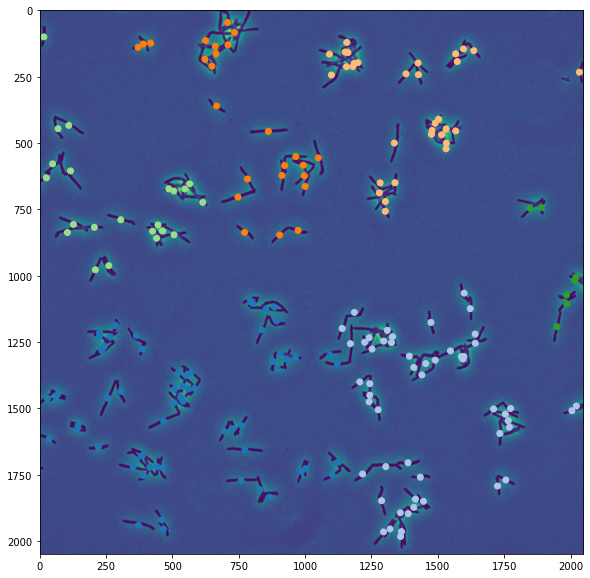

In [67]:

fig=plt.figure(figsize=(10,10))
plt.imshow(p.get_ref_image())
cluster = AgglomerativeClustering(n_clusters=None,distance_threshold=distance_threshold,linkage='complete').fit_predict(centroids)
plt.scatter(np.array(centroids)[:,1],np.array(centroids)[:,0],color=cm.get_cmap('tab20')(cluster))